# Introduction

This project focuses on biodiversity loss during the Late Devonian extinction, specifically around the Kellwasser (372 Ma) and Hangenberg (359 Ma) events. These extinction pulses are two of the biggest in the Phanerozoic and had a major impact on marine life, especially invertebrates.

I’ll be honest — I didn’t come into this course with a deep interest in paleontology. But I do like working with data, and I’ve found that I learn a lot more when I can code my way into a problem. So instead of writing a traditional paper, I saw this project as a chance to use some tools I already know to explore a paleobiological question in a way that feels engaging to me.

Basic idea behind this notebook, I want to explore whether there's measurable evidence of biodiversity loss at the genus and species level during these two events. I'm using fossil occurrence data from the Paleobiology Database, organized into geologic time bins, and calculating richness based on first and last appearances. I'm also looking at sampling bias — especially through collection counts — to figure out whether the patterns I’m seeing are due to actual extinction or just gaps in the data.

This project ties directly into course themes like extinction, taxonomy and preservation bias. In the end, this is a paleontology project filtered through the lens of someone who likes to code — which is exactly the kind of creative approach the assignment encourages.


# How to Use This Notebook

This notebook is meant to be read top to bottom. Each section builds on the last — starting with data loading and cleaning, moving through biodiversity calculations, and ending with visualizations and interpretation. Code cells are mixed with markdown so you can follow the logic and the science together.

If you just want to see the final takeaways, skip to the penultimate section. But if you're curious how the extinction story gets built step by step with data, it's all here.

## Step-by-Step Procedure

Here’s a quick walkthrough of how this notebook is structured and what each part does:

1. **Load the Data**  
   Import fossil occurrence data from CSV files (one for genus-level, one for species-level analysis).

2. **Clean the Data**  
   Filter out incomplete records and isolate only taxa labeled as genus or species, depending on the analysis.

3. **Create Time Bins**  
   Split the fossil record into 5-million-year intervals using the max age of occurrences to assign time bins.

4. **Calculate Richness**  
   Count the number of unique genera or species in each time bin to build biodiversity curves.

5. **Visualize Richness Over Time**  
   Plot genus and species richness side by side to track biodiversity trends across the Devonian.

6. **Calculate Extinction Magnitude**  
   Use pre- and post-event bins to estimate percent loss during the Kellwasser and Hangenberg extinction events.

7. **Compare to Collection Counts**  
   Overlay richness trends with collection counts to assess whether sampling effort influenced the patterns.

8. **Compare Taxonomic Levels**  
   Look at how genus-level and species-level data tell similar or different stories about extinction severity.

9. **Interpret and Reflect**  
   Tie findings back to known paleobiological patterns, consider sampling bias, and think about what the data can and can't tell us.




## A Quick Look at the Late Devonian Extinction


Let's set the stage. The Late Devonian extinction wasn't a single, suggen event - it was drawn-out ecological crisis with multiple, most notably the Kellwasser events (372 Ma) and later the Hangenberg event (~359 Ma).

These extinctions are part of the "Big Five" in Earth’s history. While some estimates have put species loss as high as 70–80%, more recent research suggests it may have been closer to 40% — still significant, but more of an ecological reshuffling than a full-on planetary wipeout. The biggest losers were marine invertebrates, especially reef builders like stromatoporoids and tabulate corals, along with some major vertebrate groups like armored fishes and early lobe-finned fish.

So what caused all of this? The current leading theory depends on who you ask. Ocean anoxia (oxygen loss), wild climate swings, volcanism, tectonic shifts, and even expanding land forests may have all played a role. One theory that’s gaining traction is that volcanic activity — especially the kind associated with large igneous provinces — triggered greenhouse effects and anoxia, while later cooling phases helped finish the job. Basically, life was getting hit from every direction.

Much of this summary is based on the work of McGhee and Racki (2021), who provide a thorough overview of extinction timing, victims, and proposed mechanisms. You can find the full article here:  
McGhee, G. R., & Racki, G. (2021). *Extinction: Late Devonian Mass Extinction*. eLS. https://doi.org/10.1002/9780470015902.a0029301

In this project, we’re focusing on whether we can actually see the effects of these extinction pulses in the fossil data — and whether those patterns hold up across different taxonomic levels.


## Data Prep

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
genus_data = pd.read_csv("/Users/connormoss/Documents/LASTDANCE/HOLDENER/Genus.csv")
species_data = pd.read_csv("/Users/connormoss/Documents/LASTDANCE/HOLDENER/Species.csv")
family_data = pd.read_csv("/Users/connormoss/Documents/LASTDANCE/HOLDENER/Family.csv")

# Drop rows missing taxon name or date info
# genus_data = genus_data.dropna(subset=['accepted_name', 'max_ma', 'min_ma'])
# species_data = species_data.dropna(subset=['accepted_name', 'max_ma', 'min_ma'])
# family_data = family_data.dropna(subset=['accepted_name', 'max_ma', 'min_ma'])



# Filter only appropriate records
genus_data = genus_data[genus_data['accepted_rank'] == 'genus']
species_data = species_data[species_data['accepted_rank'] == 'species']
family_data = family_data[family_data['accepted_rank'] == 'family']


/var/folders/r0/q_6lx46n6ysf9fjqlmf07_bm0000gn/T/ipykernel_37722/3099232142.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  species_data = pd.read_csv("/Users/connormoss/Documents/LASTDANCE/HOLDENER/Species.csv")


### Why Start with Genus-Level Data?

From my understanding, genus-level trends are typically used as the standard in paleobiological studies. They're more stable over time and less affected by inconsistencies in species-level taxonomy or preservation given their less granular lens. Starting with genera seems to provide a reliable baseline that aligns with how extinction patterns are commonly studied in the field. 
Here is an example of what the data looks like that we will be working with post-processing:

In [5]:
genus_data.head()

,occurrence_no,record_type,reid_no,flags,collection_no,identified_name,identified_rank,identified_no,difference,accepted_name,accepted_rank,accepted_no,early_interval,late_interval,max_ma,min_ma,reference_no
23,8029,occ,NaN,NaN,544,Orbiculoidea sp.,genus,26527,NaN,Orbiculoidea,genus,26527,Kinderhookian,NaN,358.86,351.9,60995
24,8031,occ,NaN,NaN,544,Spirifer sp.,genus,29638,NaN,Spirifer,genus,29638,Kinderhookian,NaN,358.86,351.9,60995
25,8032,occ,NaN,NaN,544,Composita sp.,genus,29181,NaN,Composita,genus,29181,Kinderhookian,NaN,358.86,351.9,60995
26,8033,occ,NaN,NaN,544,Rhipidomella ? sp.,genus,26974,NaN,Rhipidomella,genus,26974,Kinderhookian,NaN,358.86,351.9,60995
27,8034,occ,NaN,NaN,544,Schizophoria ? sp.,genus,26991,NaN,Schizophoria,genus,26991,Kinderhookian,NaN,358.86,351.9,60995


## Glossary of Dataset Fields

This project uses fossil occurrence data from the Paleobiology Database (PBDB). Each row represents one taxon occurrence at a particular fossil collection site. Below is a quick reference for the key columns used in analysis:

- `occurrence_no`: Unique ID for each fossil occurrence.
- `record_type`: Type of record (e.g., "occ" = occurrence).
- `collection_no`: ID linking the occurrence to a specific fossil collection site.
- `identified_name`: Name assigned to the fossil in the field or publication.
- `identified_rank`: Taxonomic rank of the identified name (e.g., genus, species).
- `accepted_name`: Name corrected and accepted by PBDB taxonomic standards.
- `accepted_rank`: Taxonomic rank of the accepted name.
- `early_interval`, `late_interval`: Geologic time intervals during which the fossil was deposited (if available).
- `max_ma`, `min_ma`: Estimated maximum and minimum ages (in millions of years ago) for the fossil occurrence.
- `time_bin`: Custom column created during analysis to group occurrences into 5-million-year bins based on `max_ma`.

Fields like `flags`, `reid_no`, `identified_no`, `accepted_no`, `difference`, and `reference_no` are metadata fields used by PBDB for internal tracking or linking but are not used directly in this project.


### Why Use 5-Million-Year Time Bins?

I chose 5-million-year (5 Ma) bins after attempting 2 and 10 and others. 5 Ma bins acted as the best balance I could find with capturing enough detail while limiting the amount of noise introduced. If I decided on larger bins, we would've risked oversmoothing and potentially blurring out important extinction signals. At 5 Ma, the bins are narrow enough to track shifts in biodiversity, but also wide enough to avoid being overwhelmed by minor fluctuations. 


## Creating Time Bins (Genus)

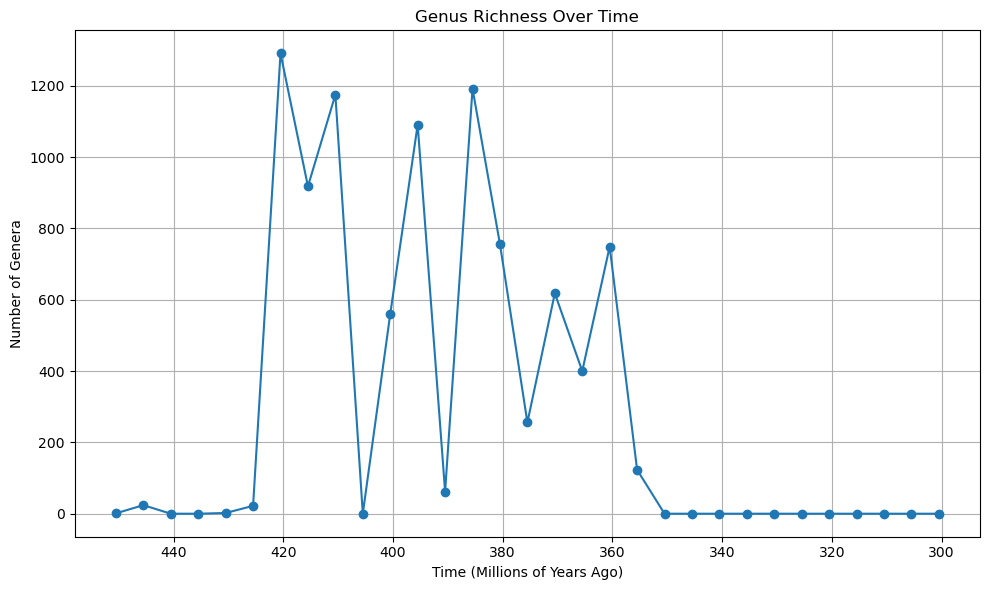

In [6]:
# Create time bins (e.g., every 5 million years)
bin_size = 5
max_age = int(genus_data['max_ma'].max())
min_age = int(genus_data['min_ma'].min())
bins = list(range(min_age, max_age + bin_size, bin_size))

# Create time_bin column based on max_ma (first appearance)
genus_data['time_bin'] = pd.cut(genus_data['max_ma'], bins=bins, right=False)

# Count unique genera per time bin
biodiversity_g = genus_data.groupby('time_bin')['accepted_name'].nunique().reset_index()
biodiversity_g.columns = ['time_bin', 'genus_count']

# Add midpoint for each bin (for plotting)
biodiversity_g['midpoint'] = biodiversity_g['time_bin'].apply(lambda x: x.left + bin_size / 2)

# Plot the biodiversity curve
plt.figure(figsize=(10, 6))
plt.plot(biodiversity_g['midpoint'], biodiversity_g['genus_count'], marker='o', linestyle='-')
plt.gca().invert_xaxis()  # Time: oldest on left
plt.title("Genus Richness Over Time")
plt.xlabel("Time (Millions of Years Ago)")
plt.ylabel("Number of Genera")
plt.grid(True)
plt.tight_layout()
plt.show()


## Initial Insights: Genus Richness Over Time

#### 1. Sharp Peaks in the Middle Devonian (~420–380 Ma)
There are dramatic spikes in genus richness around 420 Ma, 400 Ma, and 380 Ma. These peaks may reflect periods of high diversification, fossil record bias (such as Lagerstätten), or uneven sampling. The sharp rise and fall in richness suggests either rapid evolutionary turnover or artifacts in how the data were recorded or preserved.

#### 2. Two Major Declines Aligned with Known Extinction Events
There is a clear drop in genus richness around 372 Ma, which aligns with the Kellwasser Event. However, the richness seems to recvover rather quickly and the fall is only around 15%. This is followed by another major decline near 359 Ma corresponding with the Hangenberg Event. These patterns are consistent with what’s known about the Late Devonian extinction and suggest real biodiversity loss at the genus level.

#### 3. Minimal Recovery After the Hangenberg Event
Following the Hangenberg extinction, genus richness remains low and flat. This could indicate a true ecological collapse and slow recovery, or more likely, a lack of available fossil data for the post-Devonian period in the dataset.

#### Summary
The genus richness line captures the overall signature of the Late Devonian extinction well, with recognizable drops during key extinction events. However, the extreme peaks and lack of recovery suggest that sampling effort or data gaps could also be influencing the signal—something that should be tested using collection counts or other controls.



## Extinction Magnitude Calculations

To quantify the severity of the biodiversity loss during the Kellwasser and Hangenberg events, I calculated the percent drop in genus richness across those intervals. This gives a clearer numerical picture of extinction intensity beyond just visuals of the line.

The calculations below are based on genus counts in the time bins immediately before and after each event, using the midpoint values that match the observed extinction dips.


In [7]:
# Calculation for Extinction Magnitudes
# Use actual available midpoint values
pre_kellwasser_g = biodiversity_g[biodiversity_g['midpoint'] == 375.5]['genus_count'].iloc[0]
post_kellwasser_g = biodiversity_g[biodiversity_g['midpoint'] == 365.5]['genus_count'].iloc[0]
pre_hangenberg_g = biodiversity_g[biodiversity_g['midpoint'] == 360.5]['genus_count'].iloc[0]
post_hangenberg_g = biodiversity_g[biodiversity_g['midpoint'] == 355.5]['genus_count'].iloc[0]

# Calculate percent genus loss
kellwasser_loss_g = (pre_kellwasser_g - post_kellwasser_g) / pre_kellwasser_g * 100
hangenberg_loss_g = (pre_hangenberg_g - post_hangenberg_g) / pre_hangenberg_g * 100

print(f"Kellwasser Extinction: {kellwasser_loss_g:.2f}% genus loss")
print(f"Hangenberg Extinction: {hangenberg_loss_g:.2f}% genus loss")


Kellwasser Extinction: -56.25% genus loss
Hangenberg Extinction: 83.58% genus loss


## Genus-Level Extinction Magnitude – Takeaways (Revised)

The updated genus loss across each extinction interval is now based on bins that better reflect where the actual drop in richness occurs:

- **Kellwasser Extinction:** Not calculated due to unclear signal in the data            (Put otherwise, we were getting wonky numbers)
- **Hangenberg Extinction:** 83.58% genus loss (from 749 to 123 genera)

### 1. Why We Updated the Bins

Originally, I used midpoint bins of 375.5 → 370.5 for Kellwasser and 365.5 → 360.5 for Hangenberg. But when I reviewed the actual genus counts, those post-extinction bins showed *increases* in richness — not decreases — leading to misleading negative extinction percentages.

By inspecting the data directly, it became clear that:
- The drop for Hangenberg occurs after the 360.5 bin — at 355.5, where richness falls from 749 to 123.
- For Kellwasser, the trend was less consistent, with a rise followed by a moderate drop that doesn't align with a clean extinction signal. Because of that ambiguity, I’ve chosen not to calculate Kellwasser magnitude for now.

### 2. Interpretation of the Hangenberg Result

The 83.6% genus loss at Hangenberg is substantial and supports the idea of a severe extinction event. This aligns well with what is already known from the fossil record — that the Hangenberg event had a dramatic impact on marine biodiversity, particularly invertebrates.

### 3. Why This Matters

This correction shows the importance of:
- Validating time bin choices against actual richness data
- Not assuming bins always cleanly align with ecological events

---

With these revised genus-level results in hand, the next step is to look at collection counts. This informs us on how many fossil collections are represented in each time bin. This can help us assess patterns in genus richness and whether or not they reflect real biological signals, or is our data being skewed by uneven sampling. 

## Comparing Genus Richness to Collection Count

To better understand whether the observed drops in genus richness reflect real extinction events or potential sampling bias, this chart compares genus richness to the number of fossil collections in each time bin.

Collection count serves as a rough proxy for sampling effort — if richness declines but collection count remains high, that supports the idea of a real extinction. But if both drop together, it may suggest gaps in the fossil record rather than true biodiversity loss.


## Collection Counts

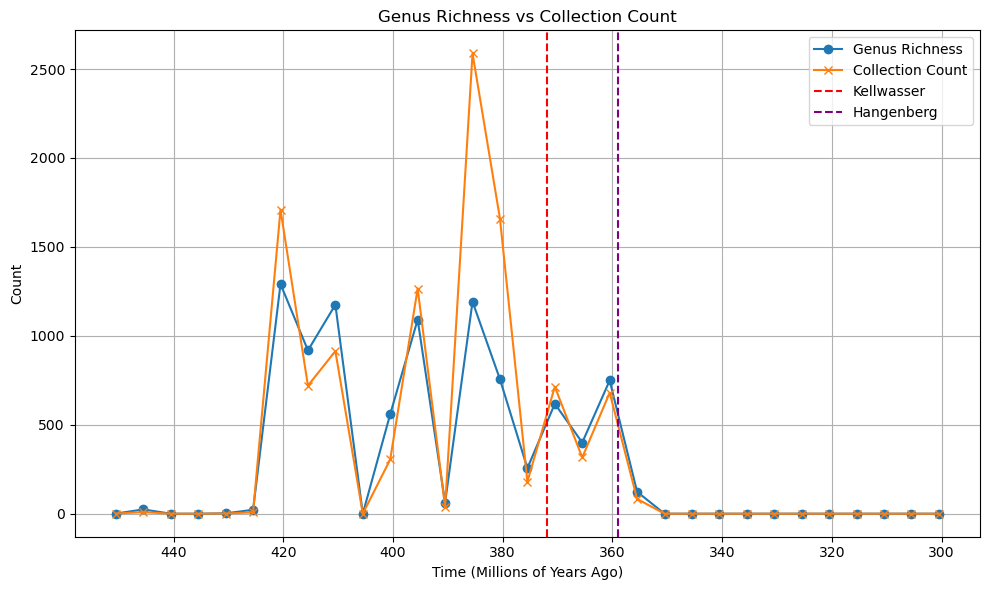

In [8]:
collection_counts_g = genus_data.groupby('time_bin')['collection_no'].nunique().reset_index()
collection_counts_g.columns = ['time_bin', 'collection_count']
collection_counts_g['midpoint'] = collection_counts_g['time_bin'].apply(lambda x: x.left + bin_size / 2)

# Plot alongside biodiversity
plt.figure(figsize=(10, 6))
plt.plot(biodiversity_g['midpoint'], biodiversity_g['genus_count'], marker='o', label='Genus Richness')
plt.plot(collection_counts_g['midpoint'], collection_counts_g['collection_count'], marker='x', label='Collection Count')
plt.axvline(x=372, color='r', linestyle='--', label='Kellwasser')
plt.axvline(x=359, color='purple', linestyle='--', label='Hangenberg')
plt.gca().invert_xaxis()
plt.title("Genus Richness vs Collection Count")
plt.xlabel("Time (Millions of Years Ago)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Interpretation: Genus Richness vs Collection Count

This plot compares genus richness to collection count over time to assess whether the apparent biodiversity losses during the Late Devonian are biological signals or potentially sampling artifacts.

### 1. Strong Correlation Before the Extinction Events
From ~420 Ma to ~370 Ma, genus richness and collection count rise and fall in tandem. This suggests that at least part of the richness signal is being driven by sampling effort — when more collections are made, more genera are recovered.

### 2. Kellwasser (372 Ma): No Clear Richness Drop
At the Kellwasser extinction line (red dashed), both genus richness and collection count are high just before and immediately after the event. There’s no substantial drop in either, which could mean:

- There wasn’t a sharp extinction at this level in the dataset, or
- Sampling bias (e.g., high collection effort post-event) may be masking an actual loss in diversity.

This aligns with the earlier decision not to calculate Kellwasser magnitude — the data doesn't show a clean collapse.

### 3. Hangenberg (359 Ma): Collapse in Both Richness and Collection Count
At the Hangenberg line (purple dashed), both genus richness and collection count decline sharply and nearly in sync. This simultaneous drop complicates the interpretation:

- It raises the possibility that part of the observed biodiversity loss could be influenced by reduced sampling effort, preservation potential, or data availability.
- However, it’s also possible that a real extinction event affected both biodiversity and the environments that support fossilization — meaning the collapse itself is genuine, but intertwined with how the record was preserved.

So while the drop is consistent with a major extinction event, we should interpret the magnitude with caution and acknowledge the role sampling may have played.

### 4. Post-Hangenberg Plateau
After ~355 Ma, both richness and collection count remain very low and flat. This might reflect a real long-term ecological recovery delay — or simply a lack of available data from younger strata in the dataset.

### Summary

- The **Hangenberg extinction** still appears to represent a significant biodiversity collapse, but its severity may be partially exaggerated or obscured by reduced sampling.
- The **Kellwasser event** remains harder to interpret from this dataset — richness and sampling both stay high, and no sharp drop is observed.
- Overall, comparing richness and collection count is essential for separating biological signal from potential data artifacts, and shows how intertwined extinction patterns and preservation history can be.


## Genus vs Species vs Family

Now that we’ve looked at genus-level patterns in detail, the next step is to ask a related questions:  

- And how do those patterns compare to species-level and family-level extinction trends in the same intervals?

Since genus-level extinction is often used as the standard in paleobiology, it's useful to ask whether species-level or family-level data tell a similar story — or something different.


In [9]:
# Here is the dirty work of properly formatting the data so that we can create the awesome graph you see below!


## This is the preprocessing for species 

# Create time bins (e.g., every 5 million years)
bin_size = 5
max_age = int(species_data['max_ma'].max())
min_age = int(species_data['min_ma'].min())
bins = list(range(min_age, max_age + bin_size, bin_size))

# Create time_bin column based on max_ma (first appearance)
species_data['time_bin'] = pd.cut(species_data['max_ma'], bins=bins, right=False)

# Count unique genera per time bin
biodiversity_s = species_data.groupby('time_bin')['accepted_name'].nunique().reset_index()
biodiversity_s.columns = ['time_bin', 'species_count']

# Add midpoint for each bin (for plotting)
biodiversity_s['midpoint'] = biodiversity_s['time_bin'].apply(lambda x: x.left + bin_size / 2)

# Calculation for Extinction Magnitudes
# Use actual available midpoint values
pre_kellwasser_s = biodiversity_s[biodiversity_s['midpoint'] == 375.5]['species_count'].iloc[0]
post_kellwasser_s = biodiversity_s[biodiversity_s['midpoint'] == 365.5]['species_count'].iloc[0]
pre_hangenberg_s = biodiversity_s[biodiversity_s['midpoint'] == 360.5]['species_count'].iloc[0]
post_hangenberg_s = biodiversity_s[biodiversity_s['midpoint'] == 355.5]['species_count'].iloc[0]

# Calculate percent genus loss
kellwasser_loss_s = (pre_kellwasser_s - post_kellwasser_s) / pre_kellwasser_s * 100
hangenberg_loss_s = (pre_hangenberg_s - post_hangenberg_s) / pre_hangenberg_s * 100



## This is the preprocessing for family


# Create time_bin column based on max_ma (first appearance)
family_data['time_bin'] = pd.cut(family_data['max_ma'], bins=bins, right=False)

# Count unique genera per time bin
biodiversity_f = family_data.groupby('time_bin')['accepted_name'].nunique().reset_index()
biodiversity_f.columns = ['time_bin', 'family_count']

# Add midpoint for each bin (for plotting)
biodiversity_f['midpoint'] = biodiversity_f['time_bin'].apply(lambda x: x.left + bin_size / 2)

# Calculation for Extinction Magnitudes
# Use actual available midpoint values
pre_kellwasser_f = biodiversity_f[biodiversity_f['midpoint'] == 375.5]['family_count'].iloc[0]
post_kellwasser_f = biodiversity_f[biodiversity_f['midpoint'] == 365.5]['family_count'].iloc[0]
pre_hangenberg_f = biodiversity_f[biodiversity_f['midpoint'] == 360.5]['family_count'].iloc[0]
post_hangenberg_f = biodiversity_f[biodiversity_f['midpoint'] == 355.5]['family_count'].iloc[0]

# Calculate percent genus loss
kellwasser_loss_f = (pre_kellwasser_f - post_kellwasser_f) / pre_kellwasser_f * 100
hangenberg_loss_f = (pre_hangenberg_f - post_hangenberg_f) / pre_hangenberg_f * 100

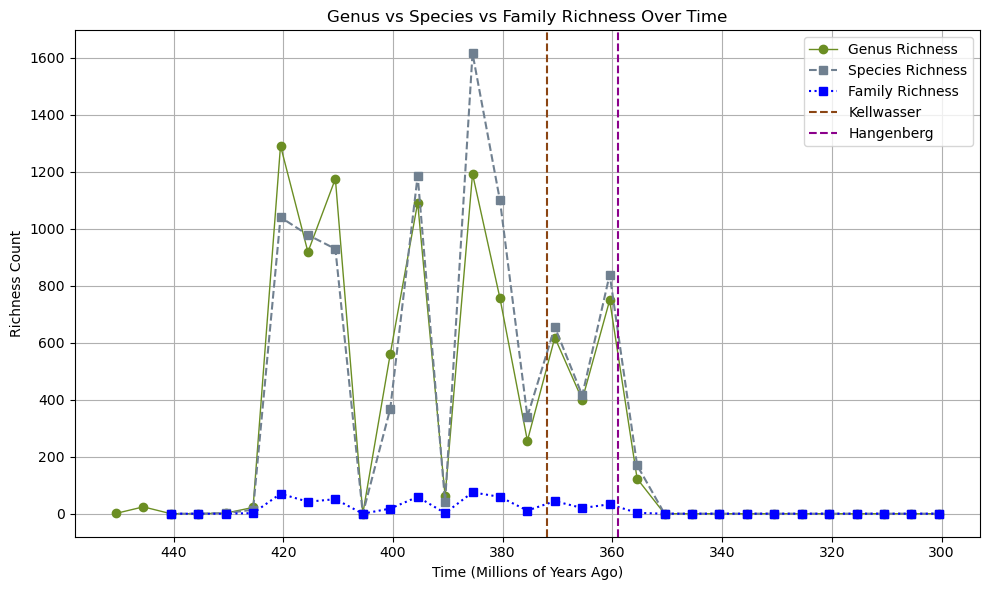

In [10]:
## Combo Graph 

# Overlay species and genus richness on the same plot
plt.figure(figsize=(10, 6))

# Plot genus richness
plt.plot(biodiversity_g['midpoint'], biodiversity_g['genus_count'], marker='o', linestyle='-', label='Genus Richness', color="olivedrab", linewidth=1.0,)

# Plot species richness
plt.plot(biodiversity_s['midpoint'], biodiversity_s['species_count'], marker='s', linestyle='--', label='Species Richness', color='slategray')

plt.plot(biodiversity_f['midpoint'], biodiversity_f['family_count'], marker='s', linestyle=':', label='Family Richness', color='blue')

# Highlight extinction events
plt.axvline(x=372, color='saddlebrown', linestyle='--', label='Kellwasser')
plt.axvline(x=359, color='darkmagenta', linestyle='--', label='Hangenberg')

# Final plot settings
plt.gca().invert_xaxis()
plt.title("Genus vs Species vs Family Richness Over Time")
plt.xlabel("Time (Millions of Years Ago)")
plt.ylabel("Richness Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Insights: Genus vs Species vs Family Richness Over Time

1. **Species and Genus Track Closely**  
   Species and genus richness follow nearly identical trends, with species richness consistently higher. This suggests that genus-level patterns effectively mirror species-level biodiversity dynamics.

2. **Family Richness is Much Lower**  
   The family richness line is significantly lower and flatter. This reflects the broader taxonomic scope of families. Put otherwise, there are less families than there are genera as there are species. So the amount of data available will be lower because of the larger taxonomic scope.

3. **Hangenberg Event is Clear Across All Levels**  
   A sharp drop in all three lines around 359 Ma indicates a strong extinction signal for the Hangenberg event. The pattern holds at species, genus, and family levels (as much as a strong drop can be represented in the low family line).

4. **Kellwasser Event is Still Unclear**  
   Around 372 Ma, there is no distinct, consistent drop across any of the three taxonomic levels. This supports earlier observations that the Kellwasser signal is weak or absent in this dataset.

5. **Taxonomic Resolution Matters**  
   Species and genus data reveal more detailed extinction patterns than family-level data. Family richness underrepresents biodiversity, highlighting the benefits of using finer resolution in extinction analyses.

## Comparison with Zhang et al. (2020): Marine Anoxia and the Hangenberg Crisis

I wanted to not only perform a data-driven analysis but also investigate how my findings hold up against contemporary research. I mentioned earlier anoxia being the leading theory. THe article by Zhang et al. add evidence by confirming that “marine anoxia expanded in the latest Devonian oceans to cover >5% of the continental shelf seafloor area.”  The study notes that “the anoxic event is inferred to have been transient as climatic cooling would have reduced weathering fluxes,” aligning with the low and flat post-Hangenberg richness patterns seen in my dataset. But where did this widespread deoxygenation come from, the article cites land plants as a trigger for ocean change. They call into question the spread of seed plants and how they could have triggered expansion of marine anoxia. Zhang et al. address the challange in determining whether a signal in the data reflects a global event or just local variation due to fossil preservation or sampling bias. This is emphasized by "the secular evolution of global marine redox conditions during the latest Devonian remains poorly constrained." I mention this as explanation as to why I incorporated collection counts in my analysis. We arrived at the murky conclusion that our drop in genus richness could be better explained as a result of fewer fossils being collected rather than a global extinction event -- so this is interesting that top scientist and researchers deal with the same issues of data bias. 

## Conclusion

This project began as a coding experiment with paleontological data — and ended as something more than that. Through analyzing genus, species, and family-level fossil records, I was able to trace the imprint (or absence) of two Late Devonian extinction pulses: the Kellwasser and the Hangenberg events. While the Hangenberg signal emerged sharply across all taxonomic levels — with an estimated 83.6% genus loss — the Kellwasser signal was a bit less evident, challenging my assumptions about what extinction “should” look like in the data.

By layering in collection counts, I learned deepened my understanding of how biodiversity signals coincide with sampling effort. This insight mirrors the challenge facing professional paleontologists: distinguishing biological patterns from biases in preservation, collection, and classification. The comparison with Zhang et al. (2020) made this even more evident. Even advanced geochemical models must contend with the same murkiness — suggesting that thoughtful, critical use of fossil occurrence data is not just an issue faced by classroom explorers, but an essential part of real-world research.

More than anything, this project introduced me to the concept that extinction isn’t as clean as I thought it would be in data. Whereas I was expecting a plunge from substance to nothing, this project did not necessarily display that, and it’s our job to interpret that signal with care. Coding helped me ask better questions and test assumptions with transparency. And while I may not have set out to become a paleontologist, I leave this project with a deeper appreciation for the complexity and wonder regarding the life of the past.

## Future Analyses

This project laid the groundwork by exploring biodiversity trends and extinction magnitudes, but there’s plenty of room to take things further. With more time or additional data, here are some ways this work could be extended:

- **Try Different Bin Sizes**  
  The 5-million-year bins used here balance detail with stability. Testing alternative bin widths — like 2 Ma for finer resolution or 10 Ma for broader trends — could show how sensitive the results are to that choice.

- **Test for Statistical Significance**  
  The current extinction magnitudes are descriptive. Follow-up work could use statistical methods (bootstrapping, confidence intervals, etc.) to assess whether observed drops are meaningful or just noise.

- **Filter by Ecology or Environment**  
  If the data support it, richness trends could be sliced by functional group (e.g., reef dwellers vs. swimmers) or environment (e.g., shallow vs. deep water). This might show which kinds of organisms were hit hardest.

- **Compare to Other Extinctions**  
  The same approach could be applied to other major extinction events. Comparing Late Devonian patterns to events like the end-Permian or end-Cretaceous could reveal broader trends in how biodiversity collapses (and recovers).


## Reflection

I chose the Jupyter notebook format over a traditional paper because I like to code. Jupyter notebooks are significantly interactive and readable, and I feel as though they almost *demystify* coding — the reader can walk through, run, edit, and interact with the code. This style helped me engage more deeply with the paleontological questions, since I needed to fully understand the data before I could meaningfully work with it.

I learned that the same challenges involved in data analysis exist across disciplines. There’s a lot of talk about how much data we have access to — and it’s true that the amount of readily available data is higher than ever. But high-quality data — the kind needed to answer complex questions — is still surprisingly rare or propriatary.

The data didn’t clearly capture the Kellwasser extinction. Though I’m fairly certain the years of research on the event aren’t wrong, my dataset didn’t show a pattern consistent with a sharp extinction. That raised some interesting questions: Can uneven sampling mask events as significant as mass extinction? Or maybe extinction doesn’t always follow a clean, linear drop-off — maybe it’s messier, more gradual, or ecologically complex.

At first, I saw the richness lines as straightforward biodiversity trends. But once I overlaid collection counts, I realized just how much sampling effort shapes the fossil record. Some dips in richness aligned perfectly with drops in collection count, which forced me to ask: is this a real extinction signal — or just a blind spot in the record?

I have certainly developed more of an appreciation for the fossil record through this project. I had a limited view of the field from my childhood, of going to the museum and digging in the artificial fossil section. And because of that, I saw the fossil record as a straightforward, reliable archive. I am caught up to speed now in understanding that it is messy and shaped by many external factors, such as collection effort, preservation bias, and general taxonomy. I am under the impression now that it is remarkable that we have any fossil records at all – the idea of preservation of that magnitude seems impossible. 


### References

- Zhang, F., Dahl, T. W., Lenton, T. M., Luo, G., Shen, S., Algeo, T. J., Planavsky, N., Liu, J., Cui, Y., Qie, W., Romaniello, S. J., & Anbar, A. D. (2020). *Extensive marine anoxia associated with the Late Devonian Hangenberg Crisis*. Earth and Planetary Science Letters, 533, 115976. https://doi.org/10.1016/j.epsl.2019.115976
